# 📑 Making the Most of Markdown within Argilla TextFields

As you may have noticed, Argilla supports Markdown within its text fields. This means you can easily add formatting like **bold**, *italic* or highlighted text, [links](https://www.google.com), and even insert HTML elements like images, audios, videos, and iframes. It's a powerful tool to have at your disposal. Let's dive in!

In this notebook, we will go over the basics of Markdown, and how to use it within Argilla.

* Exploiting the power of `displaCy` for NER and relationship extraction.
* Exploring multi-modality: video, audio, and image.
* Inspecting PDFs.

Let's get started!

> **Friendly Reminder:** Multimedia in Markdown is here, but it's still in the experimental phase. As we navigate the early stages, there are limits on file sizes due to ElasticSearch constraints, and the visualization and loading times may vary depending on your browser. We're on the case to improve this and welcome your feedback and suggestions! 🌟🚀

## Running Argilla

For this tutorial, you will need to have an Argilla server running. There are two main options for deploying and running Argilla:


**Deploy Argilla on Hugging Face Spaces**: If you want to run tutorials with external notebooks (e.g., Google Colab) and you have an account on Hugging Face, you can deploy Argilla on Spaces with a few clicks:

[![deploy on spaces](https://huggingface.co/datasets/huggingface/badges/raw/main/deploy-to-spaces-lg.svg)](https://huggingface.co/new-space?template=argilla/argilla-template-space)

For details about configuring your deployment, check the [official Hugging Face Hub guide](https://huggingface.co/docs/hub/spaces-sdks-docker-argilla).


**Launch Argilla using Argilla's quickstart Docker image**: This is the recommended option if you want [Argilla running on your local machine](../../getting_started/quickstart.html). Note that this option will only let you run the tutorial locally and not with an external notebook service.

For more information on deployment options, please check the Deployment section of the documentation.

<div class="alert alert-info">

Tip
    
This tutorial is a Jupyter Notebook. There are two options to run it:

- Use the Open in Colab button at the top of this page. This option allows you to run the notebook directly on Google Colab. Don't forget to change the runtime type to GPU for faster model training and inference.
- Download the .ipynb file by clicking on the View source link at the top of the page. This option allows you to download the notebook and run it on your local machine or on a Jupyter Notebook tool of your choice.
</div>

## Set up the Environment

To complete this tutorial, you will need to install the Argilla client and a few third-party libraries using `pip`:

In [ ]:
# %pip install --upgrade pip
%pip install argilla
%pip install datasets
%pip install spacy spacy-transformers
%pip install Pillow
%pip install span_marker
%pip install soundfile librosa
!python -m spacy download en_core_web_sm

Let's make the needed imports:

In [ ]:
import argilla as rg
from argilla.client.feedback.utils import audio_to_html, image_to_html, video_to_html, pdf_to_html

import re
import os
import pandas as pd
import span_marker
import tarfile
import glob
import subprocess
import random

import spacy
from spacy import displacy

from datasets import load_dataset

from huggingface_hub import hf_hub_download

If you are running Argilla using the Docker quickstart image or Hugging Face Spaces, you need to init the Argilla client with the `URL` and `API_KEY`:

In [ ]:
# Replace api_url with the url to your HF Spaces URL if using Spaces
# Replace api_key if you configured a custom API key
# Replace workspace with the name of your workspace
rg.init(
    api_url="http://localhost:6900", 
    api_key="owner.apikey",
    workspace="admin"
)

If you're running a private Hugging Face Space, you will also need to set the [HF_TOKEN](https://huggingface.co/settings/tokens) as follows:

In [ ]:
# # Set the HF_TOKEN environment variable
# import os
# os.environ['HF_TOKEN'] = "your-hf-token"

# # Replace api_url with the url to your HF Spaces URL
# # Replace api_key if you configured a custom API key
# rg.init(
#     api_url="https://[your-owner-name]-[your_space_name].hf.space", 
#     api_key="admin.apikey",
#     extra_headers={"Authorization": f"Bearer {os.environ['HF_TOKEN']}"},
# )

## Exploiting `displaCy`

[SpaCy](https://spacy.io/) is a well-know open-source library for Natural Language Processing (NLP). It provides a wide range of models for different languages, and it is very easy to use. One of the provided options is [`displaCy`](https://spacy.io/usage/visualizers) a visualizer for the output of the NLP models. In this tutorial, we will be using it to visualize the output of the NER model.

### Using `displaCy`

First, we will explain how `displaCy` works by importing the English SpaCy pipeline (`en_core_web_sm`) while excluding the default NER component. Later, we replace this component by using the `add_pipe` method to introduce the new `span_marker` component at the pipeline's conclusion. This new component is responsible for conducting NER training with the specified model.

In [ ]:
# Load the custom pipeline
nlp = spacy.load(
    "en_core_web_sm", 
    exclude=["ner"]
)
nlp.add_pipe("span_marker", config={"model": "tomaarsen/span-marker-bert-tiny-fewnerd-coarse-super"})

Now, you can check how using the `displacy.render` function, which takes in the text and the output of the model, returns a HTML string. BBelow, two examples are provided: the first illustrates the sentence's dependency tree, while the second showcases the NER findings.

In [3]:
# Show the dependency parse
doc = nlp("Rats are various medium-sized, long-tailed rodents.")
displacy.render(doc, style="dep")

c:\Users\sarah\miniconda3\envs\argilla\lib\site-packages\datasets\table.py:1395: FutureWarning: promote has been superseded by mode='default'.
  block_group = [InMemoryTable(cls._concat_blocks(list(block_group), axis=axis))]
c:\Users\sarah\miniconda3\envs\argilla\lib\site-packages\datasets\table.py:1421: FutureWarning: promote has been superseded by mode='default'.
  table = cls._concat_blocks(blocks, axis=0)


In [12]:
# Show the entity recognition
text = "When Sebastian Thrun started working on self-driving cars at Google in 2007, few people outside of the company took him seriously."
doc2 = nlp(text)
displacy.render(doc2, style="ent")

> You can also add custom highlights to the text by using `create_token_highlights` and a custom color map. For example:
> 
> ```python
> from argilla.client.feedback.utils import create_token_highlights
> tokens = ["This", "is", "a", "test"]
> weights = [0.1, 0.2, 0.3, 0.4]
> html = create_token_highlights(tokens, weights, c_map=custom_RGB) # 'viridis' by default
> ```
>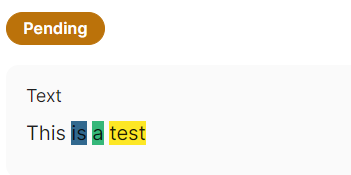

### Example: creating a `FeedbackDataset` with the displaCy output

In the example, we show how to create an Argilla `FeedbackDataset` adding the displaCy output to it. This way, we can check the accuracy of the model and asses whether the user want to apply a correction to the dependencies and/or entities.



First, we [configure the `FeedbackDataset`](/practical_guides/create_dataset.html#configure-the-dataset). In fields, we use three TextField to show the default text, dependencies and entities. While, in questions, we add a LabelQuestion, a  MultiLabelQuestion and two TextQuestions.

In [2]:
# Create the FeedbackDataset configuration
dataset_spacy = rg.FeedbackDataset(
    fields=[
        rg.TextField(name="text", required= True, use_markdown=True),
        rg.TextField(name="dependency-tree", required= True, use_markdown=True),
        rg.TextField(name="entities", required= True, use_markdown=True)
    ],
    questions=[
        rg.LabelQuestion(name="relevant", title="Is the text relevant?", labels=["Yes", "No"], required=True),
        rg.MultiLabelQuestion(name="question-multi", title="Mark which is correct", labels=["flag-pos", "flag-ner"], required=True),
        rg.TextQuestion(name="dependency-correction", title="Write the correct answer if needed", use_markdown=True),
        rg.TextQuestion(name="ner-correction", title="Write the correct answer if needed", use_markdown=True)
    ]
)
dataset_spacy

FeedbackDataset(
    fields=[TextField(name='text', title='Text', required=True, type='text', use_markdown=True), TextField(name='dependency-tree', title='Dependency-tree', required=True, type='text', use_markdown=True), TextField(name='entities', title='Entities', required=True, type='text', use_markdown=True)]
    questions=[LabelQuestion(name='relevant', title='Is the text relevant?', description=None, required=True, type='label_selection', labels=['Yes', 'No'], visible_labels=None), MultiLabelQuestion(name='question-multi', title='Mark which is correct', description=None, required=True, type='multi_label_selection', labels=['flag-pos', 'flag-ner'], visible_labels=None), TextQuestion(name='dependency-correction', title='Write the correct answer if needed', description=None, required=True, type='text', use_markdown=True), TextQuestion(name='ner-correction', title='Write the correct answer if needed', description=None, required=True, type='text', use_markdown=True)]
    guidelines=Non

Now, we load the basic [few-nerd dataset from Hugging Face](https://huggingface.co/datasets/DFKI-SLT/few-nerd). This dataset contains a few sentences, and the output of the NER model. We will be using this dataset to show how to use displaCy within Argilla.

In [ ]:
# Read the HF dataset
dataset_fewnerd = load_dataset("DFKI-SLT/few-nerd", "supervised", split="train[:20]")

Next, we will use this dataset to populate our Argilla `FeedbackDataset`. We will be using the `displacy.render` function to render the displacy output as html setting `jupyter=False`, and add it to the `FeedbackDataset`. We will also add the text, and the output of the NER model to the `FeedbackDataset`. Finally, we will also add markdown formatted tables to support basic support for NER and dependency annotation.

In [15]:
# Load the custom pipeline
nlp = spacy.load(
    "en_core_web_sm", 
    exclude=["ner"]
)
nlp.add_pipe("span_marker", config={"model": "tomaarsen/span-marker-bert-tiny-fewnerd-coarse-super"})

# Read the dataset and run the pipeline
texts = [" ".join(x["tokens"]) for x in dataset_fewnerd]
docs = nlp.pipe(texts)

In [ ]:
# Define the function to set the correct width and height of the SVG element
def wrap_in_max_width(html):
    html = html.replace("max-width: none;", "")
    
    # Remove existing width and height setting based on regex width="/d"
    html = re.sub(r"width=\"\d+\"", "overflow-x: auto;", html)
    html = re.sub(r"height=\"\d+\"", "", html)
    
    # Find the SVG element in the HTML output
    svg_start = html.find("<svg")
    svg_end = html.find("</svg>") + len("</svg>")
    svg = html[svg_start:svg_end]

    # Set the width and height attributes of the SVG element to 100%
    svg = svg.replace("<svg", "<svg width='100%' height='100%'")

    # Wrap the SVG element in a div with max-width and horizontal scrolling
    return f"<div style='max-width: 100%; overflow-x: auto;'>{svg}</div>"

In [ ]:
# Add the records to the FeedbackDataset
records = []
for doc in docs:
    record = rg.FeedbackRecord(
        fields={
            "text": doc.text, 
            "dependency-tree": displacy.render(doc, style="dep", jupyter=False), 
            "entities": displacy.render(doc, style="ent", jupyter=False)
        },
        suggestions=[{
                "question_name": "dependency-correction", 
                "value": pd.DataFrame([{"Label": token.dep_, "Text": token.text} for token in doc]).to_markdown(index=False)

            },
            {
                "question_name": "ner-correction", 
                "value": pd.DataFrame([{"Label": ent.label_, "Text": ent.text} for ent in doc.ents]).to_markdown(index=False),
            }
        ]
    )
    records.append(record)
    
dataset_spacy.add_records(records)

In [ ]:
# Push the dataset to Argilla
dataset_spacy = dataset_spacy.push_to_argilla(name="exploiting_displacy", workspace="admin")

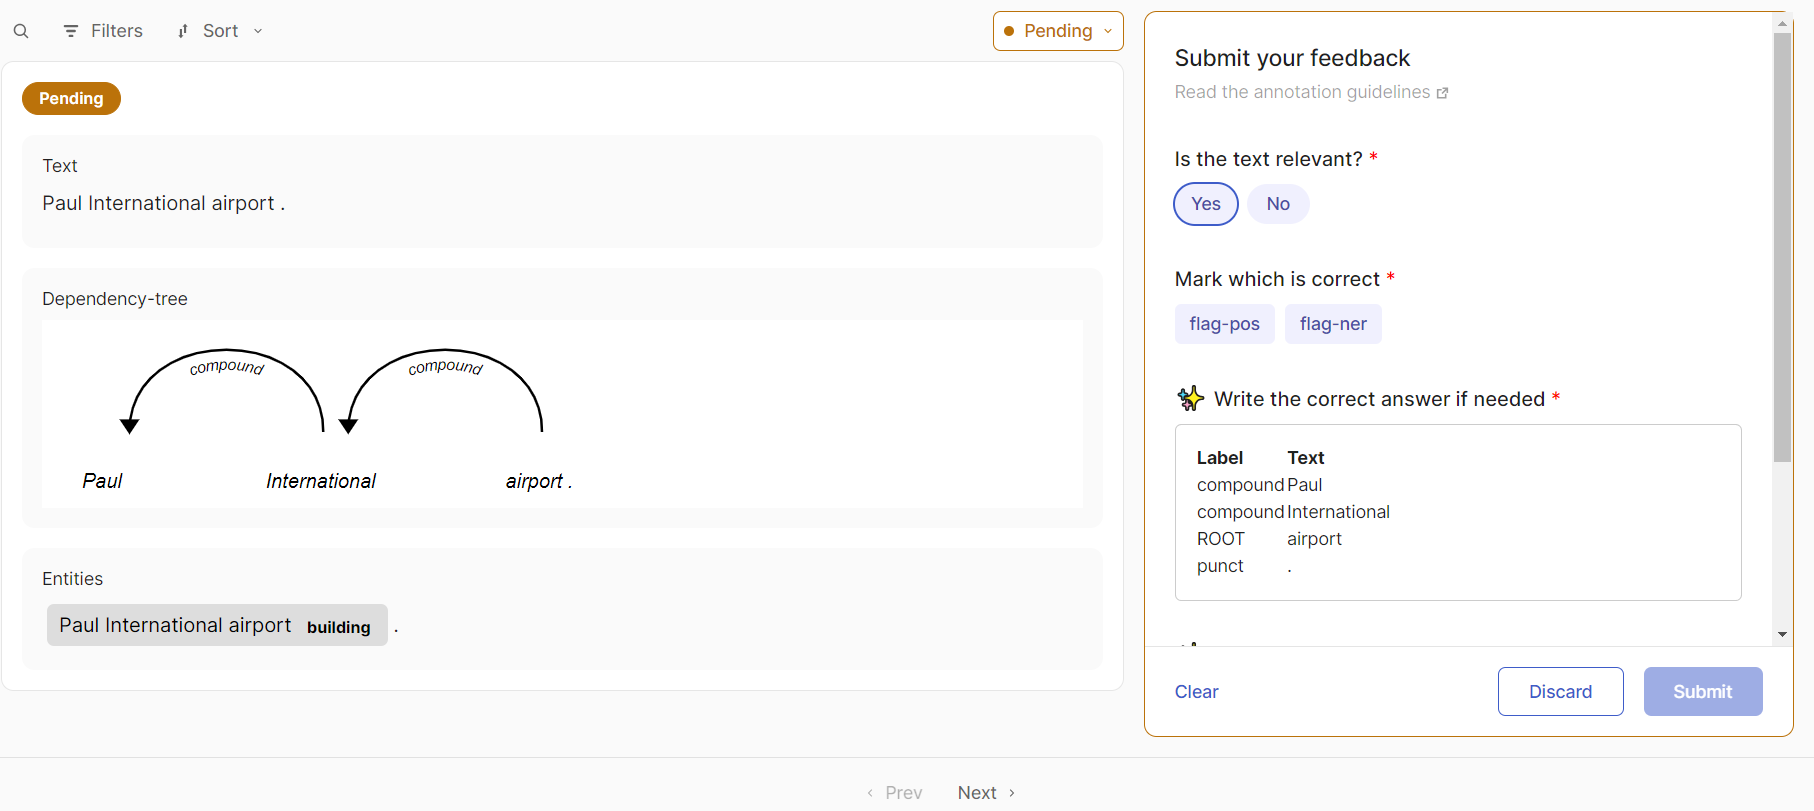

## Exploring Multi-Modality: Video, Audio and Image

As we already mentioned, Argilla supports handling video, audio, and images within markdown fields, provided they are formatted in HTML. To facilitate this, we offer three functions: `video_to_html`, `audio_to_html`, and `image_to_html`. These functions accept either the file path or the file's byte data and return the corresponding HTMurl to render the media file within the Argilla user interface. Additionally, you can also set the `width` and `height` in pixel or percentage for video and image (defaults to the original dimensions) and the `autoplay` and `loop` attributes to `True` for audio and video (defaults to False).


We will define our `FeedbackDataset` with a TextField to add the media content. We will also add a question to ask the user to describe the video, audio, or image file.

In [4]:
# Configure the FeedbackDataset
ds_multi_modal = rg.FeedbackDataset(
    fields=[rg.TextField(name="content", use_markdown=True, required=True)],
    questions=[rg.TextQuestion(name="description", title="Describe the content of the media:", use_markdown=True, required=True)],
)
ds_multi_modal

FeedbackDataset(
    fields=[TextField(name='content', title='Content', required=True, type='text', use_markdown=True)]
    questions=[TextQuestion(name='description', title='Describe the content of the media:', description=None, required=True, type='text', use_markdown=True)]
    guidelines=None)
)

We will use the corresponding functions to the `add_records`-method and we add the media content to the `FeedbackDataset`.

In [24]:
# Add the records
records = [
    rg.FeedbackRecord(fields={"content": video_to_html("/content/snapshot.mp4", autoplay=True)}),
    rg.FeedbackRecord(fields={"content": audio_to_html("/content/sea.wav", autoplay=True, loop=True)}),
    rg.FeedbackRecord(fields={"content": image_to_html("/content/peacock.jpg", width="50%", height="50%")}),
]
ds_multi_modal.add_records(records)

In [ ]:
# Push the dataset to Argilla
ds_multi_modal = ds_multi_modal.push_to_argilla("multi-modal-basic", workspace="admin")

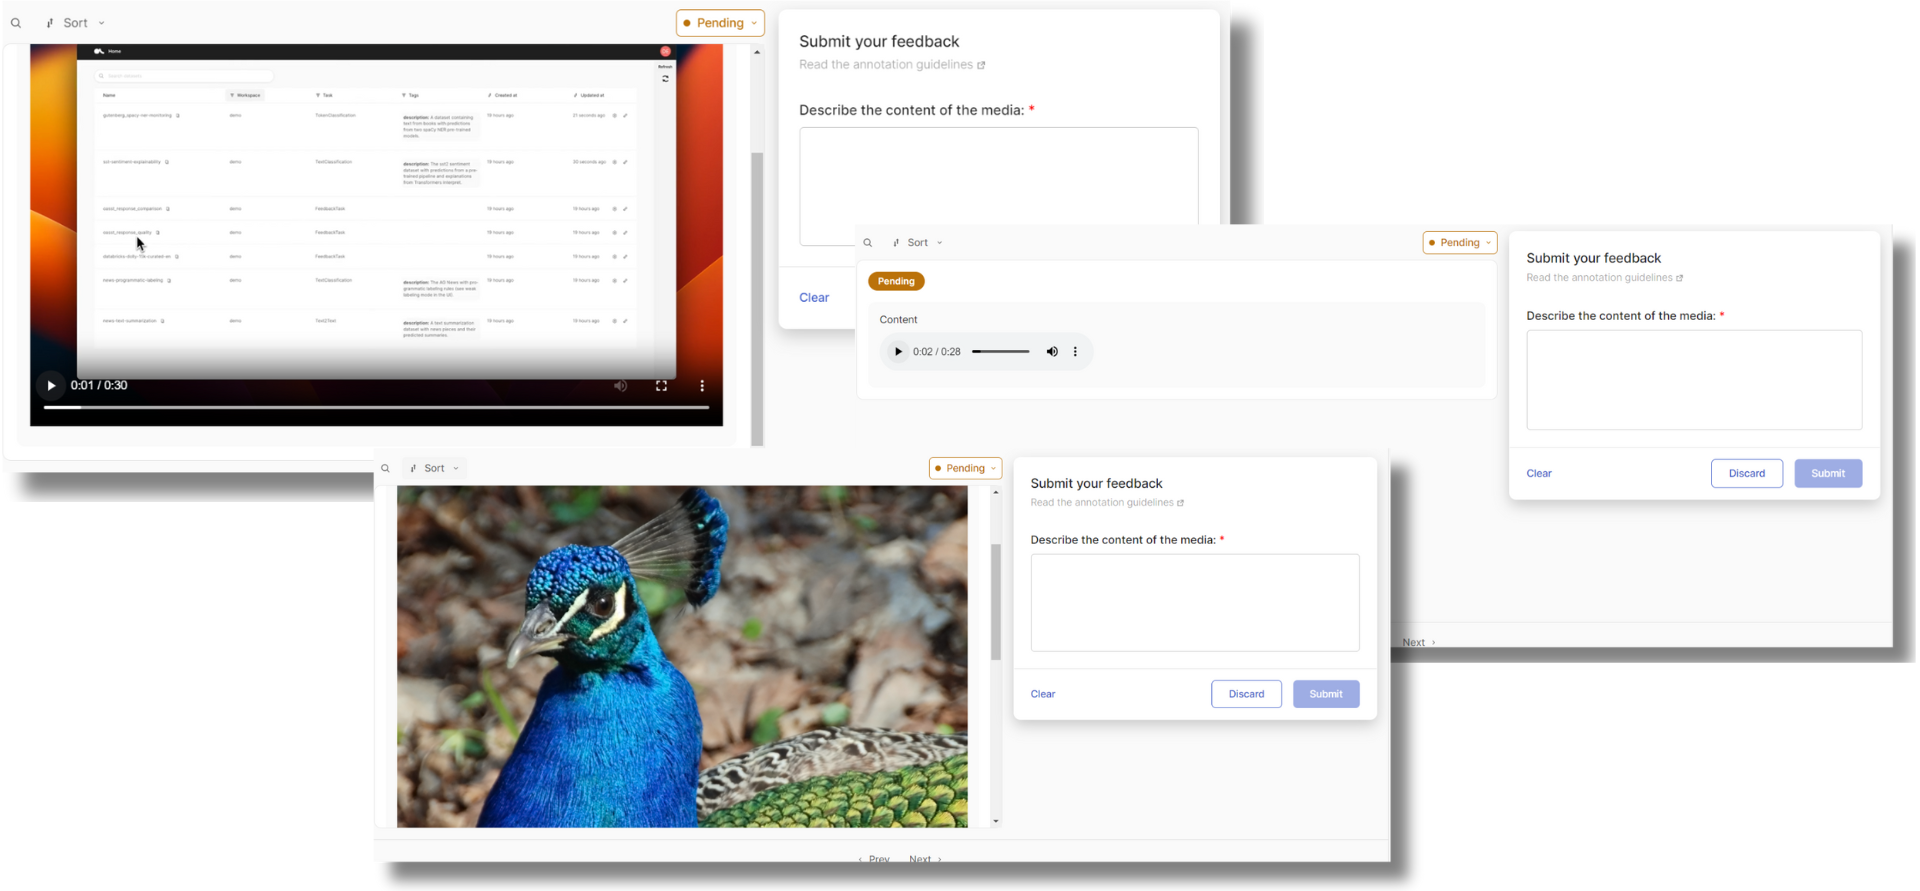

### Example: Creating a multi-modal-video-audio-image `FeedbackDataset`

A multi-modal dataset can be used to create a dataset with text and different types of media content. It can be useful for different tasks, such as image captioning, video captioning, audio captioning, and so on. Now, we will create our own  as examples that will combine videos, audio and images that can be filtered using the metadata properties.

For this purpose, we will be using three different datasets from Hugging Face:

* **Video**: We use an action recognition dataset, the [ucf101-subset](https://huggingface.co/datasets/sayakpaul/ucf101-subset) from the [UCF101](https://www.crcv.ucf.edu/data/UCF101.php). This dataset contains realistic action videos from YouTube, classified in 101 actions.

* **Audio**: We use an audio classification dataset, the [ccmusic-database/bel_folk](https://huggingface.co/datasets/ccmusic-database/bel_folk). This dataset contains 1 minute audio clips of Chinese folk music, and the genre of the music.

* **Image**: We use an image classification dataset, the [zishuod/pokemon-icons](https://huggingface.co/datasets/zishuod/pokemon-icons). This dataset contains images of Pokemon that need to be classified.

First of all, we will create the configuration of our Feedback dataset. This will involve a few key components:

- TextField: This will be used for adding the media content.
- TextQuestion: A feature to describe the content in detail.
- RatingQuestion: This will allow us to rate the content's quality effectively.
- LabelQuestion: An essential part for tagging the content with the most suitable age group.

Additionally, we will enhance the configuration with three metadata properties to streamline content management:

- The first property will identify the assigned annotator group.
- The second will specify the media source.
- The third will highlight the source dataset of the content in each record.

In [ ]:
# We configure the FeedbackDataset
multi_modal_dataset = rg.FeedbackDataset(
    guidelines="Please, read the question carefully and try to answer it as accurately as possible.",
    fields=[
        rg.TextField(name="content", use_markdown=True, required=True),
    ],
    questions=[
        rg.TextQuestion(
            name="description",
            title="Describe the content of the media.", 
            use_markdown=True, 
            required=True
        ),
        rg.RatingQuestion(
            name="quality",
            description="Rate the overall quality of the content on a scale from 1 to 5.",
            required=True,
            values=[1, 2, 3, 4, 5]
        ),
        rg.LabelQuestion(
            name="age_group",
            description="Select the most appropriate age group for this content.",
            required=True,
            labels = ["Children", "Teens", "Adults", "All Ages"]
        ),
    ],
    metadata_properties = [
        rg.TermsMetadataProperty(
            name="groups",
            title="Annotation groups",
            values=["group-a", "group-b", "group-c"],
        ),
        rg.TermsMetadataProperty(
            name="media",
            title="Media source",
            values=["video", "audio", "image"],
        ),
        rg.TermsMetadataProperty(
            name="source-dataset",
            title="Original dataset source",
        ),
    ],
    allow_extra_metadata = False
)

try:
    multi_modal_dataset = rg.FeedbackDataset.from_argilla("multi-modal")
except:
    multi_modal_dataset = multi_modal_dataset.push_to_argilla("multi-modal")

multi_modal_dataset

Then, we need to load and preprocess the datasets to be able to add the media content to the `FeedbackDataset`.

* Video content: We download the dataset and unzip it. Then, from the train, we randomly select two .avi files from each class and use ffmpeg to convert them to .mp4.

In [ ]:
# Download the dataset
hf_dataset_identifier = "sayakpaul/ucf101-subset"
filename = "UCF101_subset.tar.gz"
file_path = hf_hub_download(repo_id=hf_dataset_identifier, filename=filename, repo_type="dataset")

In [ ]:
# Unpack the files
with tarfile.open(file_path) as t:
     t.extractall(".")

In [ ]:
# Set the paths to the input and output directories.
base_directory = "/content/UCF101_subset/train"
output_directory = "/content/UCF101_subset/random"

# Check if the output directory exists, if not, create it.
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Iterate over the directories (each corresponding to a class) in the 'train' folder.
for folder in os.listdir(base_directory):
    folder_path = os.path.join(base_directory, folder)
    
    # Check if it's a directory.
    if os.path.isdir(folder_path):
        # Get all .avi files in the directory.
        avi_files = glob.glob(os.path.join(folder_path, "*.avi"))
        
        # Randomly select 2 .avi files.
        selected_files = random.sample(avi_files, 2)
        
        for avi_file in selected_files:
            # Define the output .mp4 file path.
            mp4_file = os.path.join(output_directory, os.path.basename(avi_file).replace(".avi", ".mp4"))
            
            # Command to convert .avi to .mp4 using ffmpeg.
            command = f"ffmpeg -i \"{avi_file}\" -c:v libx264 -c:a aac \"{mp4_file}\""
            
            try:
                subprocess.run(command, check=True, shell=True)
                print(f"Converted {avi_file} to {mp4_file}")
            except subprocess.CalledProcessError as e:
                print(e)

print("Conversion process is complete.")

* Audio content: We load the first 20 samples from HF and shuffle them.

In [ ]:
my_audio_dataset = load_dataset("ccmusic-database/bel_folk", split="train[:20]")
my_audio_dataset = my_audio_dataset.shuffle()

In [ ]:
my_audio_dataset[0]

{'audio': {'path': '/root/.cache/huggingface/datasets/downloads/extracted/1ce3c7fd0658e784a55187bcf1d5dccffc4dadff041a3bd7abb7d399eb383d9e/dataset/audio/Bel_f (32).wav',
  'array': array([-1.19754369e-03, -1.13605941e-03, -3.28621594e-04, ...,
          4.34814254e-04,  2.44393945e-04,  7.59907998e-05]),
  'sampling_rate': 44100},
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=476x349>,
 'label': 1,
 'gender': 0,
 'singing_method': 1}

* Image dataset: We load the first 20 samples from HF and shuffle them.

In [ ]:
my_image_dataset  = load_dataset("zishuod/pokemon-icons", split="train[:20]")
my_image_dataset = my_image_dataset.shuffle()

In [ ]:
my_image_dataset[0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=72x72>,
 'label': 4}

Finally, we will add and push the data to our FeedbackDataset. We will use the `video_to_html`, `audio_to_html`, and `image_to_html` functions to add the content.

* Adding the video records

In [ ]:
# Set the directory where we saved our samples
random_dir = output_directory

# Get a list of all entries in the directory
entries = os.listdir(random_dir)

# Shuffle the list of entries to avoid any bias
random.shuffle(entries)

# Iterate over all the entries in random order
for entry in entries:
    
    # Define the full path
    fullPath = os.path.join(random_dir, entry)

    # Add the records to the FeedbackDataset
    record = rg.FeedbackRecord(
        fields={"content": video_to_html(fullPath)},
        metadata={"groups":"group-a", "media":"video", "source-dataset":"https://huggingface.co/datasets/sayakpaul/ucf101-subset"}
    )
    try:
        multi_modal_dataset.add_records(record, show_progress=True)
    except Exception as e:
        print(e)
        pass

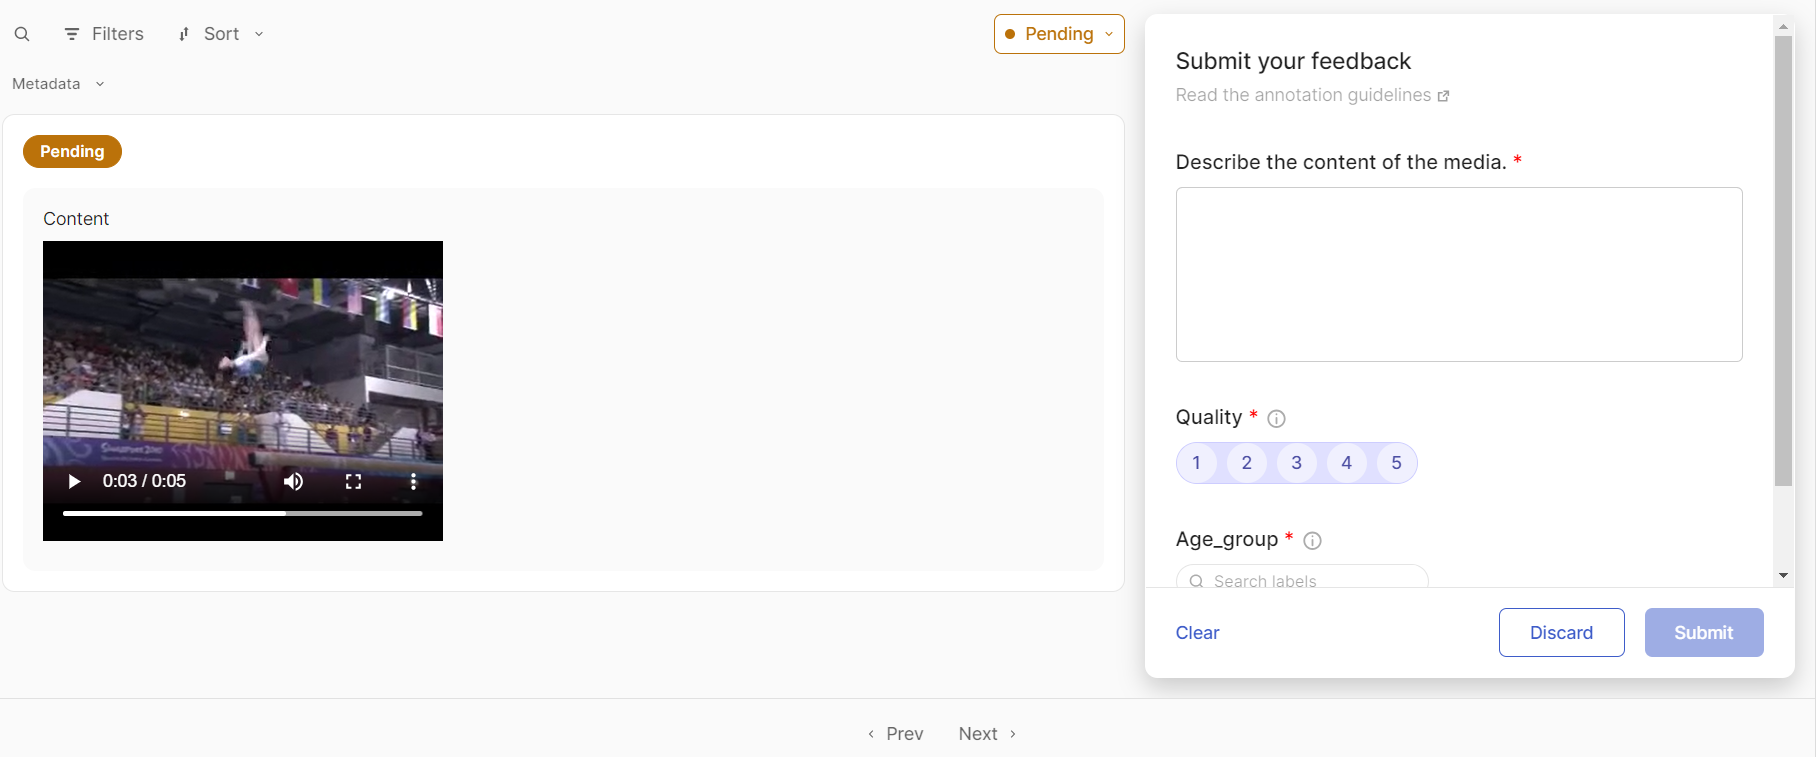

* Adding the audio records

In [ ]:
# Iterate over the samples in the dataset
for entry in my_audio_dataset:
    
    # Add the records to the FeedbackDataset
    record = rg.FeedbackRecord(
        fields={"content": audio_to_html(entry["audio"]["path"])},
        metadata={"groups":"group-b", "media":"audio", "source-dataset":"https://huggingface.co/datasets/ccmusic-database/bel_folk"}
    )
    try:
        multi_modal_dataset.add_records(record, show_progress=True)
    except Exception as e:
        print(e)
        pass

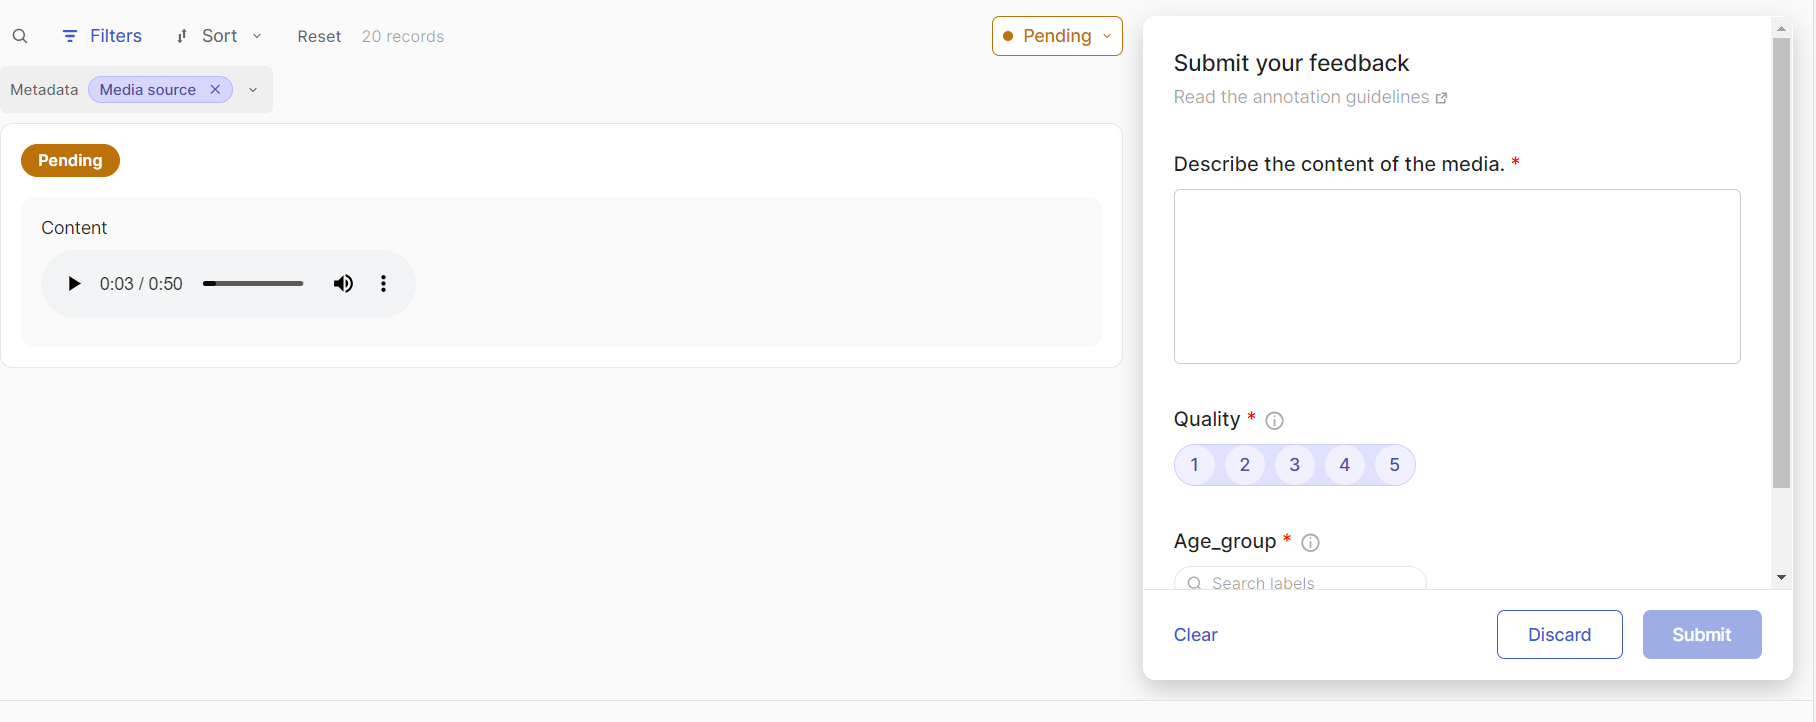

* Adding the image records

In [ ]:
# Set a temporary path to save the image
temp_img_path = "temp_img.png"

# Iterate over the samples in the dataset
records = []
for entry in my_image_dataset:
    
    # Save the image to the temporary path
    entry["image"].save(temp_img_path, format="png")
    
    # Add the records to the FeedbackDataset
    record = rg.FeedbackRecord(
        fields={"content": image_to_html(temp_img_path, file_type="png")},
        metadata={"groups":"group-c", "media":"image", "source-dataset":"https://huggingface.co/datasets/zishuod/pokemon-icons"}
    )
    try:
        multi_modal_dataset.add_records(record, show_progress=True)
    except Exception as e:
        print(e)
        pass

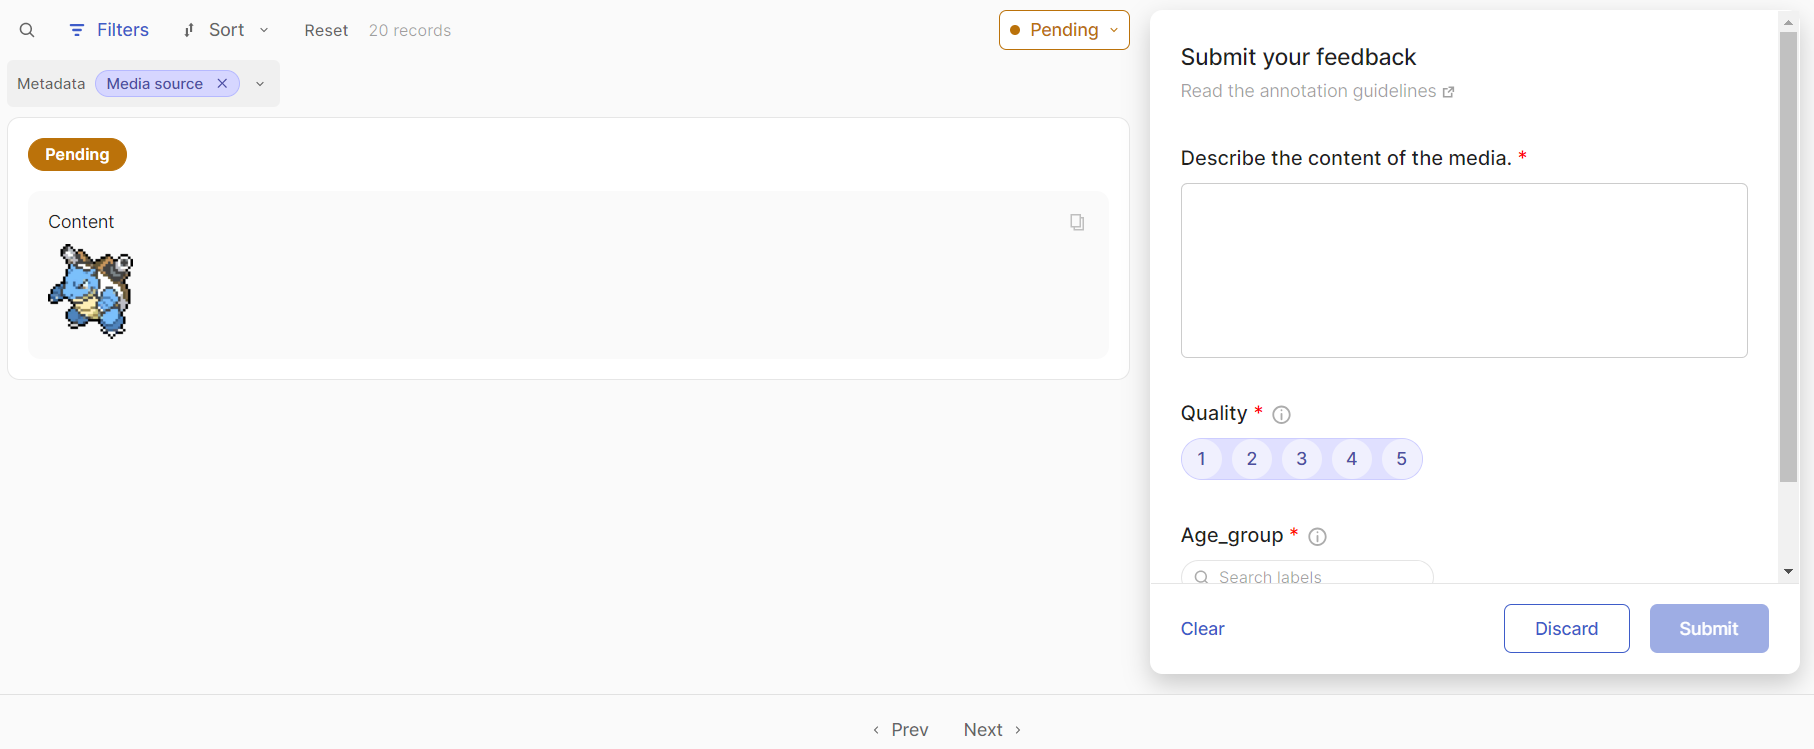

To finish, we can push the FeedbackDataset to HuggingFace.

In [ ]:
# Push to HuggingFace Hub
multi_modal_dataset.push_to_huggingface("argilla/multi-modal-dataset")

## Inspecting PDFs

Argilla also supports PDFs. You can add a PDF to a TextField by using the `pdf_to_html` function similarly to what we have done before. This function accepts either the **file path**, the **URLs** or the **file's byte data** and returns the corresponding HTML to render the PDF within the Argilla user interface. Optionally, you can also set the `width` and `height` in pixel or percentage (defaults to 1000px). Below, you can see an example of how to use this function.

In [ ]:
# In this case, we will use the URL of the PDF file
file_url = "https://arxiv.org/pdf/2310.06825.pdf"

# Configure the FeedbackDataset
ds_pdf = rg.FeedbackDataset(
    fields=[
        rg.TextField(name="content", use_markdown=True, required=True),
    ],
    questions=[
        rg.TextQuestion(name="description", use_markdown=True, required=True)
    ],
)

# Push the dataset to Argilla
ds_pdf = ds_pdf.push_to_argilla(name='analyze_pdf_dataset', workspace='argilla')

# Add the records using pdf_to_html
records = [
    rg.FeedbackRecord(fields={"content": pdf_to_html(file_source=file_url, width="700px", height="700px")})]
ds_pdf.add_records(records)

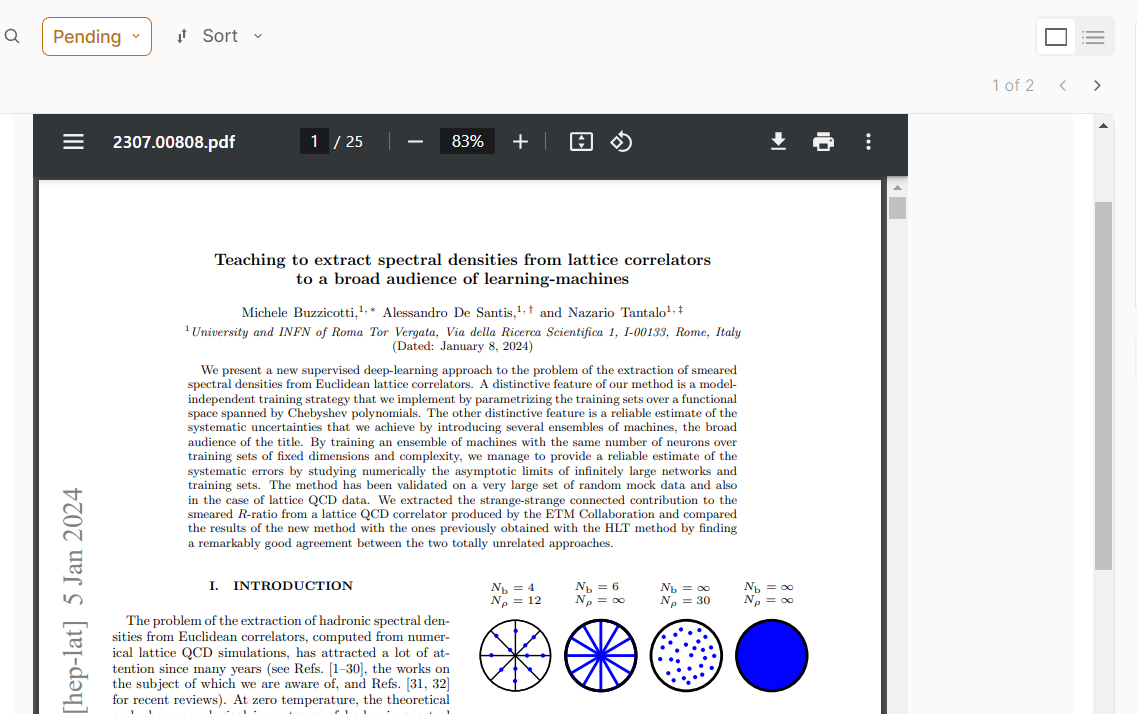

<div class="alert alert-info">

Tip

You can also view your `.docx`, `.pptx` or `.xlsx` in the Argilla UI setting `use_markdown=True` and embedding it if they are on a public URL. For instance, you can upload them to your Google Drive and get the public URL by changing the sharing settings to "Anyone with the link can view".
    
```python
file_url = "your-sharable-link.xlsx"
html = f"<embed src={file_url} type=application/pdf width=700px height=700px/></embed>"

ds = rg.FeedbackDataset(...)

records = [
    rg.FeedbackRecord(fields={"xlsx_file": html})]
ds.add_records(records)

ds = ds.push_to_argilla(name='xlsx', workspace='argilla')
```

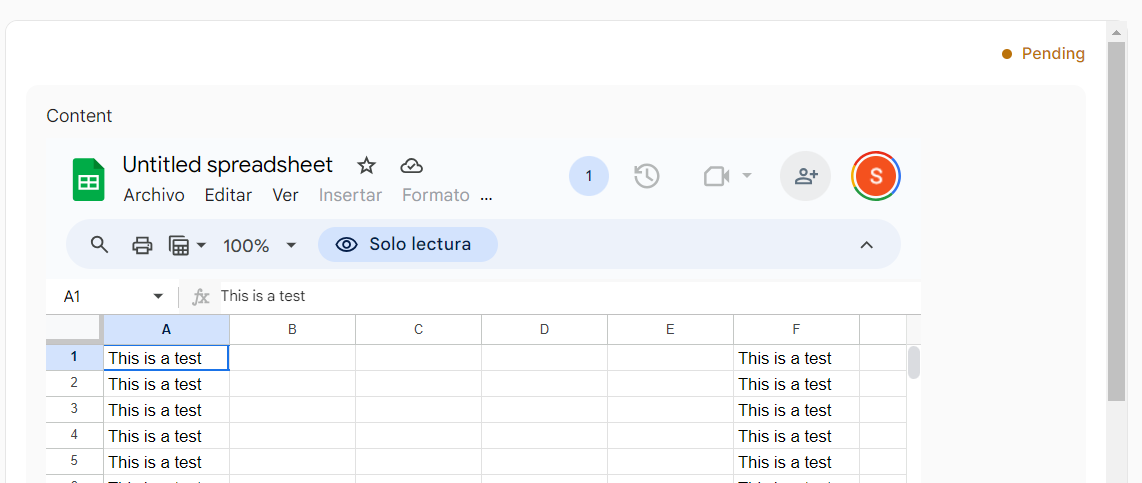

</div>

 Now that you've learned the Markdown tips, it's your turn to create you own multi-modal FeedbackDataset! 🔥